In [1]:
import re 
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from simhash import Simhash
import matplotlib.pyplot as plt
import editdistance

def seed_everything(seed: int):
    import random, os
    import numpy as np
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

# 核心算法

In [2]:
# MSKTS文本相似度比對算法
url = 'https://gist.githubusercontent.com/skywalker0803r/7c00d680d731b99ab549dd40a96006ce/raw/d9bb060a42285053faa5227df521b43f381f1a0b/MSKTS.py'
exec(requests.get(url).text)

# help function

In [3]:
# 只保留英文字母
def keep_alpha(str1): 
  char = "" 
  for x in str(str1):
    if x.isalpha(): 
      char = "".join([char, x])
  return char

# 基於規則之關鍵字匹配算法
def matching(sentence,database,use_X000D=False):
  candidate_list = []
  for word in database:
    if word in sentence: 
      candidate_list.append(word)
  if (use_X000D == True) and (len(candidate_list) == 0):
    candidate_list.append(sentence.split('_X000D')[0])
  if len(candidate_list) == 0:
    candidate_list.append('not find')
  return candidate_list

# string_list中的string若為其他string的"子集"則剔除
def substringSieve(string_list):
    string_list.sort(key=lambda s: len(s), reverse=True)
    out = []
    for s in string_list:
      if not any([s in o for o in out]):
        out.append(s)
    return out

# 去除多重空白
def remove_multiple_blanks(x):
  for i in range(2,10,1):
    x = x.replace(' '*i,' ')
  return x

# 輸入sentence前處理
def preprocess_raw_sentence(x):
  x = str(x).upper() # 轉大寫字串
  x = re.sub('[\u4e00-\u9fa5]', '', x) # 去除中文
  x = re.sub(r'[^\w\s]','',x) # 去除標點符號
  x = x.replace('\n', '').replace('\r', '').replace('\t', '') # 去除換行符號
  str.strip(x) # 移除左右空白
  x = remove_multiple_blanks(x) # 去除多重空白
  x = ' ' + x + ' '# 出現在頭的 就不可能對到前後加空格的 這種情形要想想怎麼對照(加上左右空白)
  return x

# 字串長度小於3的單詞前後加空白
def add_space(x):
    if (' ' not in x) and (len(x)<=3): 
        return ' ' + x + ' '
    else:
        return x

# 產品後處理
def product_name_postprocess(x):
  x = str(x).split('(')[0] # 擷取括號前面的字串
  x = str(x).upper() # 轉大寫字串
  x = re.sub(r'[^\w\s]','',x) # 去除標點符號
  x = x.strip() # 去除空白
  x = add_space(x)# 字串長度小於3的單詞前後加空白
  return x

# 基於關鍵字比對方法的預測函數
def predict_keyword(title,test_df,Unrecognized,input_col,database,output_col,use_X000D=False):
  result = []
  for i in tqdm(test_df.index):
    candidate_list = matching(
        sentence = test_df.loc[i,input_col],
        database = set(database) - set(Unrecognized),
        use_X000D = use_X000D
        )
    result.append(substringSieve(candidate_list))
  test_df[output_col] = result
  return test_df

# 取得dataframe的空列表索引
def get_empty_list_idx(df,col):
  error_idx = []
  for idx,name in enumerate(df[col].values.tolist()):
    if len(name) == 0:
      error_idx.append(idx)
  return error_idx

# 公司英文名稱模糊比對函數
def 公司英文名稱模糊比對函數(input_data,公司寶典):
    # 去[]
    input_data = input_data[0]
    # 去尾綴
    for 尾綴 in 公司寶典['尾綴']:
      input_data = input_data.replace(尾綴,'')
    # 去空白
    input_data = input_data.strip()
    # 幾種意外情況
    if input_data == 'not find':
      return [input_data]
    if input_data.encode('utf-8').isalpha() == False:
      return [input_data]
    # 模糊搜索最相似公司
    score = {}
    for history_data in 公司寶典['公司英文名稱']:
        score[history_data] = editdistance.eval(input_data,history_data)
    return min(score,key=score.get)

# 公司英文名稱2代號函數
def 公司英文名稱2代號函數(input_data,公司寶典):
    score = {}
    for history_data in 公司寶典['公司英文名稱']:
      score[history_data] = editdistance.eval(input_data,history_data)
    return 公司寶典.loc[公司寶典['公司英文名稱']==min(score,key=score.get),'代號']

# 載入數據


In [4]:
# 歷史資料庫
database = pd.read_excel('../data/combined_excel.xlsx')
# 新的測試數據
test_data = pd.read_csv('../data/測試數據/0927到2022.csv')

# 讀取"產品名"寶典
品名寶典 = pd.read_excel('../data/寶典/寶典人工處理後/寶典.v8.202111202.xlsx',engine='openpyxl')[['CODIV','DIVNM','ITEMNM']]
品名寶典 = 品名寶典.rename(columns={'ITEMNM':'品名','DIVNM':'公司事業部門','CODIV':'公司代號'})
品名寶典['品名'] = 品名寶典['品名'].apply(lambda x:product_name_postprocess(x))

# 讀取"開狀人"寶典
開狀人寶典 = pd.read_csv('../data/寶典/開狀人寶典.csv')

# 讀取"公司"寶典
公司寶典 = pd.read_csv('../data/寶典/公司寶典加尾綴.csv',index_col=0).astype(str).reset_index(drop=True)

In [5]:
new_row = pd.DataFrame([['2','NANYA PLASTICS','CORPORATION']],columns=['代號','公司英文名稱','尾綴'])
公司寶典 = 公司寶典.append(new_row)
公司寶典

,代號,公司英文名稱,尾綴
0,1,FORMOSA PLASTICS,CORPORATION
1,2,NAN YA PLASTICS,CORPORATION
2,4,FORMOSA CHEMICALS AND FIBRE,CORP
3,6,FORMOSA PETROCHEMICAL,CORP
4,AF,FORMOSA AUTOMOBILE SALES,CORPORATION
5,AH,FORMOSA ASAHI SPANDEX,CO LTD
6,AL,FORMOSA DAIKIN ADVANCED CHEMICALS,CO LTD
7,BM,FORMOSA BIOMEDICAL TECHNOLOGY,CORPORATION
8,BN,HONG JING RESOURCES,CO LTD
9,GF,CHANG GUNG MEDICAL TECHNOLOGY,CO LTD


In [6]:
大公司列表 = []
for i in 公司寶典['代號']:
    if (len(i) == 1):
        大公司列表.append(i)
大公司列表

['1', '2', '4', '6', 'C', 'J', '2']

In [7]:
小公司列表 = []
for i in 公司寶典['代號']:
    if (len(i) == 2) and (i[0].isalpha()) and (i[1].isalpha()):
        小公司列表.append(i)
小公司列表

['AF',
 'AH',
 'AL',
 'BM',
 'BN',
 'GF',
 'IF',
 'RS',
 'RW',
 'RZ',
 'XU',
 'XZ',
 'BQ',
 'RC',
 'RP',
 'RA',
 'RV',
 'TN',
 'TR',
 'BW']

# 按照時間排序資料

In [8]:
def sort_by_form(df):
    df = df.sort_values(by='from')
    df = df.reset_index(drop=True)
    return df
database = sort_by_form(database)
test_data = sort_by_form(test_data)

# 定義欄位

In [9]:
產品名輸入 = '45A' #產品名
開狀人輸入 = '50' #開狀人
受益人輸入 = '59' #受益人
開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
輸出欄位 = ['產品名','開狀人','受益人','開狀銀行']
輸入欄位 = ['45A','50','59','LTADDRESS.1']

# 預處理函數

In [10]:
# 針對模型輸入做預處理
def 預處理(df):
  產品名輸入 = '45A' #產品名
  開狀人輸入 = '50' #開狀人
  受益人輸入 = '59' #受益人
  開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
  for i in [產品名輸入,開狀人輸入,受益人輸入]:
    df[i] = df[i].apply(lambda x:preprocess_raw_sentence(x))
  return df

# 抽特徵函數

In [11]:
def 抽特徵(df,品名寶典=None,開狀人寶典=None,公司寶典=None):
  # 預測產品(利用品名寶典)
  df = predict_keyword(
      title = '正在預測產品',
      test_df = df,
      Unrecognized = ['PE','MA','EA','GRADE','INA','PACK','PP','PA','']+[' '*i for i in range(1,10,1)],
      input_col = 產品名輸入,
      database = list(map(lambda x:str(x).upper(),品名寶典['品名'].values.tolist())),
      output_col = '產品名',
      use_X000D = False,
      )

  # 預測開狀人(善用X000D)
  df = predict_keyword(
      title = '正在預測開狀人',
      test_df = df,
      Unrecognized = ['']+[' '*i for i in range(1,10,1)],
      input_col = 開狀人輸入,
      database = list(map(lambda x:str(x).upper(),開狀人寶典['開狀人'].values.tolist())),
      output_col = '開狀人',
      use_X000D = True,
      )

  # 搜索法預測公司(受益人)
  df = predict_keyword(
      title = '正在預測受益人',
      test_df = df,
      Unrecognized = ['']+[' '*i for i in range(1,10,1)],
      input_col = 受益人輸入,
      database = list(map(lambda x:str(x).upper(),公司寶典['公司英文名稱'].values.tolist())),
      output_col = '受益人',
      use_X000D = True,
      )
  # 受益人(公司)模糊比對,確保跟寶典上寫的一致
  df['受益人'] = df['受益人'].apply(lambda x:公司英文名稱模糊比對函數(x,公司寶典))

  # 預測開狀銀行靠規則比對篩選前8碼即可
  df['開狀銀行'] = df[開狀銀行輸入].apply(lambda x:str(x)[:8])
  return df

# 準備訓練資料

In [12]:
database = 抽特徵(預處理(database),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=database,col=i)
    print(i,'空列表數量:',len(number))
database[輸出欄位].tail(5)

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

產品名 空列表數量: 0
開狀人 空列表數量: 0
受益人 空列表數量: 0
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
20732,[NYLON 6 FILAMENT YARN],[SKY INDUSTRIES LTD],[FORMOSA CHEMICALS AND FIBRE],KKBKINBB
20733,[PVC SUSPENSION RESIN],[L D INTERNATIONAL],[FORMOSA PLASTICS],KKBKINBB
20734,"[EPOXY RESIN, NPEF]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20735,"[EPOXY RESIN, NPEL]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20736,[PVC RESIN],[PRAGYA FLEXIFILM INDUSTRIES],[FORMOSA PLASTICS],KKBKINBB


# 準備測試資料

In [13]:
test_data = 抽特徵(預處理(test_data),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=test_data,col=i)
    print(i,'空列表數量:',len(number))
test_data[輸出欄位].tail(5)

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

產品名 空列表數量: 0
開狀人 空列表數量: 0
受益人 空列表數量: 0
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
2422,"[ETHYLENEPROPYLENE COPOLYMER, PLASTIC RESIN, P...",[DRACO KING INDUSTRIES LIMITED],[FORMOSA PLASTICS],HNBKHKHH
2423,[MONO ETHYLENE GLYCOL],[CHI BAO CORPORATION],[NAN YA PLASTICS],TPBKTWTP
2424,[RESIN],[PEGASUS CHEMICALS CO LTD],[FORMOSA PLASTICS],ICBCTWTP
2425,"[COVERING, GP5350]",[BRENNTAG CANADA INC],[FORMOSA CHEMICALS AND FIBRE],NOSCCATT
2426,[PVC COPOLYMER RESIN],[S R POLYVINYL LIMITED],[FORMOSA PLASTICS],INDBINBB


# 模型測試

In [14]:
def 根據特定欄位和索引給出候選答案清單(col,idx,k,database_size=100,database=None,test_data=None):
  # 判斷是否為空列表
  if len(test_data[col][idx]) == 0:
    return []
  # 預處理
  database['處理過的資料'] = (database[col]).apply(keep_alpha)
  test_data['處理過的資料'] = (test_data[col]).apply(keep_alpha)
  # 建立模型
  model = MSKTS()
  model.fit(list(set(database['處理過的資料'].sample(database_size).values.tolist()) - set(['']+[' '*i for i in range(1,10,1)])))
  # 產生預測答案清單
  predict_answer = [i for i in model.predict(test_data['處理過的資料'][idx],k=k)]
  # 預測最相似文本
  預測最相似文本 = [i[0] for i in predict_answer]
  預測EXPNO前兩碼 = database.loc[database['處理過的資料'].isin(預測最相似文本),'EXPNO'].dropna().apply(lambda x:str(x)[:2]).values.tolist()
  # 相似度距離
  相似度距離 = [i[1] for i in predict_answer]
  # 預測完整EXPNO
  預測完整EXPNO = database.loc[database['處理過的資料'].isin(預測最相似文本),'EXPNO'].dropna().apply(lambda x:str(x)[:]).values.tolist()
  # 最相似前案
  最相似前案 = database.loc[database['處理過的資料'].isin(預測最相似文本),col].dropna().apply(lambda x:str(x)[:]).values.tolist()
  # 最相似前案時間
  最相似前案時間 = database.loc[database['處理過的資料'].isin(預測最相似文本),'from'].dropna().apply(lambda x:str(x)[:]).values.tolist()
  return 預測EXPNO前兩碼,相似度距離,預測完整EXPNO,最相似前案,最相似前案時間

In [15]:
issue_idx = test_data['受益人'][test_data['受益人'].apply(lambda x:str(x)[0])=='not find'].index
test_data.loc[issue_idx,['59','受益人']]

,59,受益人


In [16]:
test_data[輸出欄位].head()

,產品名,開狀人,受益人,開狀銀行
0,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],[FORMOSA PLASTICS],ICICINBB
1,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE
2,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE
3,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],[FORMOSA PLASTICS],INDBINBB
4,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],[NAN YA PLASTICS],BOTKJPJT


# 測試正確率

In [17]:
def 根據受益人限縮database(test_data,公司寶典):
    公司英文名稱2代號 = dict(zip(公司寶典['公司英文名稱'],公司寶典['代號']))
    公司英文名稱 = test_data['受益人'].apply(lambda x:公司英文名稱模糊比對函數(x,公司寶典)[0]).values.tolist()
    expno第一碼 = [ 公司英文名稱2代號函數(i,公司寶典).values.tolist()[0] for i in 公司英文名稱]
    return database.loc[database['EXPNO'].apply(lambda x:str(x)[0])=='2',:]

In [18]:
def 目標函數(database_size,database,test_data,test_n=20,k=1):
  # 初始化'預測EXPNO'和correct
  test_data['預測EXPNO'] = None
  correct = []
  # 先根據公司限縮database
  restricted_database = database#根據受益人限縮database(test_data,公司寶典)
  # 遍歷test_data做推論
  for idx in tqdm(range(test_n)):
    o1,d1,e1,n1,t1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=k,
      database_size=min(database_size,len(restricted_database)),
      database=restricted_database,
      test_data=test_data)
    o2,d2,e2,n2,t2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=k,
      database_size=min(database_size,len(restricted_database)),
      database=restricted_database,
      test_data=test_data)
    o3,d3,e3,n3,t3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=k,
      database_size=min(database_size,len(restricted_database)),
      database=restricted_database,
      test_data=test_data)
    o4,d4,e4,n4,t4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=k,
      database_size=min(database_size,len(restricted_database)),
      database=restricted_database,
      test_data=test_data)
    # 判斷是否為小公司
    if len(set(o3) & set(小公司列表)) > 0:
      o = list(set(o3) & set(小公司列表))
    # 判斷是否為大公司
    elif len(set([str(i[0]) for i in o3]) & set(大公司列表)) > 0:
      new_o = []
      # 從o1中做篩選
      for expno前兩碼 in o1:
        expno第一碼 = str(expno前兩碼[0])
        if expno第一碼 in 大公司列表:
          new_o.append(expno前兩碼)
      o = new_o
    # 其他情況
    else:
      o = o1 + o3
    # 對o取眾數得到ensemble_output
    try:
      try:
        ensemble_output = max(o,key=o.count)
      except:
        ensemble_output = max(o1+o3,key=(o1+o3).count)
    except:
      ensemble_output = 'not find'
    # 指派前案特徵至test_data
    for i in [n1,n2,n3,n4]:
      if len(i) == 0:
        i.append('not find')
    test_data.loc[idx,'前案產品名'] = max(n1,key=n1.count)
    test_data.loc[idx,'前案開狀人'] = max(n2,key=n2.count)
    test_data.loc[idx,'前案受益人'] = max(n3,key=n3.count)
    test_data.loc[idx,'前案開狀銀行'] = max(n4,key=n4.count)
    # 指派前案時間至test_data
    try:
      test_data.loc[idx,'最相似前案時間'] = max(t1+t2+t3+t4,key=(t1+t2+t3+t4).count)
    except:
      test_data.loc[idx,'最相似前案時間'] = 'not find'
    # 指派預測值至test_data
    test_data.loc[idx,'預測EXPNO'] = ensemble_output
    # 指派距離至test_data
    test_data.loc[idx,'相似度距離'] = np.sum(d1+d2+d3+d4)
    # 指派完整EXPNO至test_data
    完整EXPNO候選清單 =[]
    for expno in e1+e3+e3+e4:
      if expno[:2] == ensemble_output:
        完整EXPNO候選清單.append(expno)
    try:
      test_data.loc[idx,'預測完整EXPNO'] = max(完整EXPNO候選清單,key=完整EXPNO候選清單.count)
    except:
      test_data.loc[idx,'預測完整EXPNO'] = 'not find'
    # 計算正確率
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  return np.mean(correct),test_data
acc,test_data = 目標函數(database_size=len(database),database=database,test_data=test_data)
print('正確率:',acc)

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

正確率: 0.9


In [19]:
最終所有必須欄位 = 輸入欄位+輸出欄位+['相似度距離','from','20','預測EXPNO','預測完整EXPNO','推薦公司事業部',
    '最相似前案時間','前案產品名','前案開狀人','前案受益人','前案開狀銀行']
test_data.head(20).loc[test_data['預測EXPNO']!=test_data['推薦公司事業部'],最終所有必須欄位]

,45A,50,59,LTADDRESS.1,產品名,開狀人,受益人,開狀銀行,相似度距離,from,20,預測EXPNO,預測完整EXPNO,推薦公司事業部,最相似前案時間,前案產品名,前案開狀人,前案受益人,前案開狀銀行
6,14400 KG_X000D_TETRAHYDROFURAN_X000D_AS PER P...,PIRAMAL PHARMA LTD_X000D_ENNORE EXPRESS HIGHW...,NAN YA PLASTICS CORPORATION_X000D_PETROCHEMIC...,KKBKINBBACPC,[TETRAHYDROFURAN],[ PIRAMAL PHARMA LTD],[NAN YA PLASTICS],KKBKINBB,19.0,0927.xls,0462ILF210010760,2P,2PL14132,24,021-202101.xlsx,['TETRAHYDROFURAN'],['PIRAMAL PHARMA LIMITED'],['NAN YA PLASTICS'],KKBKINBB
18,18 MT EPOXIDIZED SOYA BEAN OIL_X000D__X000D_A...,ABU DHABI ISLAMIC BANK_X000D_POBOX 313 ABU DH...,7802040838_X000D_NAN YA PLASTICS CORPORATION_...,ABDIAEADAXXX,[SOYA BEAN OIL],[ABU DHABI ISLAMIC BANK],[NAN YA PLASTICS],ABDIAEAD,0.0,0927.xls,ILCAE18021000213,2M,2MQ14C43,2P,021-202101.xlsx,['SOYABEAN OIL'],['ABU DHABI ISLAMIC BANK'],['NAN YA PLASTICS'],ABDIAEAD


# 加入錯誤feedback寶典後再測試

In [20]:
feedback = pd.read_excel('../data\寶典\寶典人工處理後\寶典_feedback.xlsx',index_col=0)
display(feedback.head())

品名寶典_加入錯誤feedback = 品名寶典.append(feedback).reset_index(drop=True).drop_duplicates()
display(品名寶典_加入錯誤feedback)

database = 抽特徵(預處理(database),品名寶典=品名寶典_加入錯誤feedback,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=database,col=i)
    print(i,'空列表數量:',len(number))
display(database[輸出欄位].tail(5))

test_data = 抽特徵(預處理(test_data),品名寶典=品名寶典_加入錯誤feedback,開狀人寶典=開狀人寶典,公司寶典=公司寶典)
for i in 輸出欄位:
    number = get_empty_list_idx(df=test_data,col=i)
    print(i,'空列表數量:',len(number))
display(test_data[輸出欄位].tail(5))

acc,test_data = 目標函數(database_size=len(database),database=database,test_data=test_data)
display('正確率:',acc)

,公司代號,公司事業部門,品名
7,2E,not find,TAIRILIN BRAND POLYESTER FILM
9,25,not find,POLYESTER PET CHIP
18,4A,not find,TAIRISAN SAN RESINS
28,2P,not find,BUTANEDIOL
41,28,not find,GLASS FABRICS


,公司代號,公司事業部門,品名
0,11,塑膠事業部,COPOLYMER PVC C1250M
1,11,塑膠事業部,COPOLYMER PVC C15
2,11,塑膠事業部,COPOLYMER PVC C8
3,11,塑膠事業部,MASS PVC B57
4,11,塑膠事業部,MASS PVC B57C
...,...,...,...
1235,2P,not find,14 BUTANEDIOL
1236,4A,not find,PLASTIC RESIN
1237,4A,not find,POLYPROPYLENE
1238,2M,not find,LAMINATE


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

產品名 空列表數量: 0
開狀人 空列表數量: 0
受益人 空列表數量: 0
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
20732,[NYLON 6 FILAMENT YARN],[SKY INDUSTRIES LTD],[FORMOSA CHEMICALS AND FIBRE],KKBKINBB
20733,[PVC SUSPENSION RESIN],[L D INTERNATIONAL],[FORMOSA PLASTICS],KKBKINBB
20734,"[EPOXY RESIN, NPEF]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20735,"[EPOXY RESIN, NPEL]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20736,[PVC RESIN],[PRAGYA FLEXIFILM INDUSTRIES],[FORMOSA PLASTICS],KKBKINBB


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

產品名 空列表數量: 0
開狀人 空列表數量: 0
受益人 空列表數量: 0
開狀銀行 空列表數量: 0


,產品名,開狀人,受益人,開狀銀行
2422,"[ETHYLENEPROPYLENE COPOLYMER, PLASTIC RESIN, P...",[DRACO KING INDUSTRIES LIMITED],[FORMOSA PLASTICS],HNBKHKHH
2423,[MONO ETHYLENE GLYCOL],[CHI BAO CORPORATION],[NAN YA PLASTICS],TPBKTWTP
2424,"[ IMPACT MODIFIER, RESIN]",[PEGASUS CHEMICALS CO LTD],[FORMOSA PLASTICS],ICBCTWTP
2425,"[COVERING, GP5350]",[BRENNTAG CANADA INC],[FORMOSA CHEMICALS AND FIBRE],NOSCCATT
2426,[PVC COPOLYMER RESIN],[S R POLYVINYL LIMITED],[FORMOSA PLASTICS],INDBINBB


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

'正確率:'

0.9

# 觀察不同資料筆數 對正確率的影響

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[10, 100, 1000, 20737] [0.2, 0.65, 0.85, 0.9]


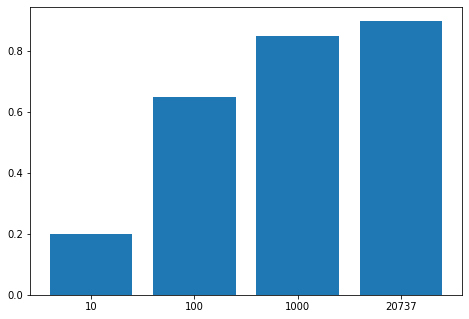

In [21]:
x = [10,100,1000,len(database)]
y = [目標函數(database_size=i,database=database,test_data=test_data)[0] for i in x]
print(x,y)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([str(i) for i in x],y)
plt.show()

# 觀察不同database對正確率的影響

In [22]:
# 載入數據
database2 = pd.read_excel('../data/combined_excel_D.xlsx')

# 欄位定義
database2col = []
for i in database2.columns:
    if 'ERP' not in i:
        database2col.append(i)

# 欄位定義
database3col = []
for i in database2.columns:
    if '電文' not in i:
        database3col.append(i)

# 切分資料
database2,database3 = database2[database2col],database2[database3col]

# 統一命名
database2 = database2.rename(
    columns={
        '產品名_電文':'45A',
        '開狀人_電文':'50',
        '受益人_電文':'59',
        '開狀銀行_電文':'LTADDRESS.1',
        '出口代碼':'EXPNO',
    })
display(database2.head())

# 統一命名
database3 = database3.rename(
    columns={
        '產品名_ERP':'45A',
        '開狀人_ERP':'50',
        '受益人_ERP':'59',
        '開狀銀行_ERP':'LTADDRESS.1',
        '出口代碼':'EXPNO',
    })
display(database3.head())

,Unnamed: 0,信用狀代碼,EXPNO,TXDAT,59,45A,50,LTADDRESS.1,from
0,0,0505120IM0000875,11A11G09,20210120,"FORMOSA PLASTICS CORPORATION\r\n201, TUNG HWA ...",108.50 MT PVC RESIN SUSPENSION GRADE S-70 OF F...,RMG POLYVINYL INDIA LTD\r\n10/1 INDUSTRIAL ARE...,SBININBBAFXD,021-20201216-1231.xlsx
1,1,FDC0129000052021,11A11J95,20210130,NaN,NaN,NaN,NaN,NaN
2,2,FDC0129000052021,11A11J95,20210130,NaN,NaN,NaN,NaN,NaN
3,3,FDC0129000052021,11A11J95,20210130,NaN,NaN,NaN,NaN,NaN
4,4,1287IMLC22754,11A12F88,20210218,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,59,45A,50,LTADDRESS.1,信用狀代碼,EXPNO,TXDAT,from
0,0,FORMOSA PLASTICS,PVC RESIN SUSPENSION \nGRADE S-70,RMG POLYVINYL INDIA LTD\n10/1 INDUSTRIAL AREA\...,STATE BANK OF INDIA,0505120IM0000875,11A11G09,20210120,021-20201216-1231.xlsx
1,1,FORMOSA PLASTICS,"MASS PVC RESIN,GRADE B-57",RUBCHEM INDIA PVT LTD,THE SOUTH INDIAN BANK LTD,FDC0129000052021,11A11J95,20210130,NaN
2,2,FORMOSA PLASTICS,"PVC SUSPENSION RESIN,\nGRADE S-65",RUBCHEM INDIA PVT LTD,THE SOUTH INDIAN BANK LTD,FDC0129000052021,11A11J95,20210130,NaN
3,3,FORMOSA PLASTICS,"PVC SUSPENSION RESIN,\nGRADE S-65D",RUBCHEM INDIA PVT LTD,THE SOUTH INDIAN BANK LTD,FDC0129000052021,11A11J95,20210130,NaN
4,4,FORMOSA PLASTICS,PVC SUSPENSION RESIN \nS-65D,ALPHA POLYMERS,THE FEDERALBANK LTD\nP B NO 20 RAMAKRISHNA ROA...,1287IMLC22754,11A12F88,20210218,NaN


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

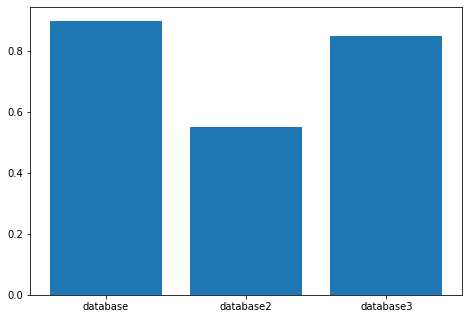

In [23]:
x = [
    抽特徵(預處理(database),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典),
    抽特徵(預處理(database2),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典),
    抽特徵(預處理(database3),品名寶典=品名寶典,開狀人寶典=開狀人寶典,公司寶典=公司寶典),
    ]
y = [目標函數(database_size=len(i),database=i,test_data=test_data,test_n=20)[0] for i in x]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['database','database2','database3'],y)
plt.show()

# 輸出預測結果

In [24]:
acc,test_data = 目標函數(
    database_size=len(database),
    database=database,
    test_data=test_data,
    test_n=len(test_data))
print(f'正確率:{acc}')
test_data[最終所有必須欄位].head()

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2427 [00:00<?, ?it/s]

正確率:0.7416563658838071


,45A,50,59,LTADDRESS.1,產品名,開狀人,受益人,開狀銀行,相似度距離,from,20,預測EXPNO,預測完整EXPNO,推薦公司事業部,最相似前案時間,前案產品名,前案開狀人,前案受益人,前案開狀銀行
0,48 MT PVC SUSPENSION RESIN GRADE S65_X000D_A...,DEEP JYOTI WAX TRADERS_X000D_PRIVATE LIMITED...,FORMOSA PLASTICS CORPORATION_X000D_201 TUNG ...,ICICINBBACTS,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],[FORMOSA PLASTICS],ICICINBB,0.0,0927.xls,0006MLC00034022,11,11N11A50,11,017-202101-03.xlsx,['PVC SUSPENSION RESIN'],['DEEP JYOTI WAX TRADERS'],['FORMOSA PLASTICS'],ICICINBB
1,TERMS OF PRICE CFR FUZHOU CHINA_X000D_ COUNT...,CHEMNEWS CORP_X000D_ROOM 601 6FL SUNGJI BUIL...,NAN YA PLASTICS CORPORATION_X000D_PETROCHEMI...,CZNBKRSEAXXX,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE,0.0,0927.xls,M100H2109SS00178,2A,2AD01224,2A,021-202104.xlsx,['MONO ETHYLENE GLYCOL MEG'],['CHEMNEWS CORP'],['NAN YA PLASTICS'],CZNBKRSE
2,TERMS OF PRICE CFR FUZHOU CHINA_X000D_ COUNT...,CHEMNEWS CORP_X000D_ROOM 601 6FL SUNGJI BUIL...,NAN YA PLASTICS CORPORATION_X000D_PETROCHEMI...,CZNBKRSEAXXX,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE,0.0,0927.xls,M100H2109SS00185,2A,2AD01224,2A,021-202104.xlsx,['MONO ETHYLENE GLYCOL MEG'],['CHEMNEWS CORP'],['NAN YA PLASTICS'],CZNBKRSE
3,PVC SUSPENSION RESIN GRADE B57 8750 MT UNIT ...,GOVERDHAN ENERGY_X000D_PETROCHEMICALS_X000D_...,FORMOSA PLASTICS CORPORATION_X000D_TAIWAN_X0...,INDBINBBANAS,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],[FORMOSA PLASTICS],INDBINBB,0.0,0927.xls,OLC0025210044889,11,11N11A50,11,017-202101-03.xlsx,['PVC SUSPENSION RESIN'],['GOVERDHAN ENERGY'],['FORMOSA PLASTICS'],INDBINBB
4,PVC TRANSPARENT SHEET TTL 17340M_X000D_03MMX...,SOJITZ CORPORATION_X000D_OSAKA OFFICE 310UME...,NAN YA PLASTICS CORPORATION_X000D_201 TUNG H...,BOTKJPJTAXXX,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],[NAN YA PLASTICS],BOTKJPJT,0.0,0927.xls,S-321-2021242,21,21K16002,21,021-202101.xlsx,['PVC TRANSPARENT SHEET'],['SOJITZ CORPORATION'],['NAN YA PLASTICS'],BOTKJPJT


# save

In [25]:
test_data[最終所有必須欄位].to_excel('../predict_result/預測結果.xlsx')

In [26]:
#ok